# Tweet Language Classification

A common text classification task involves automatically determining the language in which a document is written, based on previously-labelled example documents.

In this notebook, we will look at automatically classifying the text from tweets as either English or non-English. The dataset we will use is a subset of the [UMass Global English on Twitter Dataset](https://www.kaggle.com/rtatman/the-umass-global-english-on-twitter-dataset).

In [73]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, RepeatedKFold
%matplotlib inline

## Data Preprocessing

Firstly, read the tab-separated dataset file into a Pandas Data Frame. Here each tweet will be considered as a document. Note that URLs and user mentions have already been removed from this data.

In [74]:
df = pd.read_csv("tweet-language.tsv", sep="\t").set_index("Tweet ID")
print("Read %d documents" % len(df))

Read 6759 documents


In [75]:
df.head(10)

,Tweet,English
Tweet ID,,
285903159434563584,volkan konak adami tribe sokar yemin ederim :d,0
285965965118824448,i felt my first flash of violence at some fool...,1
286057979831275520,ladies drink and get in free till 10:30,1
286216100784521216,watching #miranda on bbc1!!! u r hilarious,1
286525170670243840,all over twitter because you and your friends ...,1
286916662836490241,"~ i'm falling apart,with a broken heart,barely...",1
286927073078018048,"oh my god, we go way back #lovethis #rahrahrah",1
286927433498759168,"the way you treat me. the way you accept me, a...",1
286941320851890177,i just wanna get pulled on the sled by the fou...,1


Our documents here are given by the *Tweet* column. Our target variable is given by the *English* column, where 1 indicates an English language tweet and 0 indicates a non-English tweet.

In [76]:
# 0 = Non-English, 1 = English
target_categories = ["Non-English", "English"]
# Content for all documents
documents = df["Tweet"]
# Class labels for all documents
target = df["English"]

We can check to see how balanced the classes in the dataset are, based on the values in the target:

In [77]:
target.value_counts()

English
1    3704
0    3055
Name: count, dtype: int64

Next, we will produce vector representations of the documents. For real applications we would want to use a custom tokenizer to handle the specifics of tweets (e.g. mentions, hashtags etc). However, for this simple example we will just use the standard scikit-learn tokenizer and a simple *CountVectorizer*.

Note that we do not use any "stop words" here. For language detection, common stop words might actually prove to be useful features.

In [78]:
vectorizer = CountVectorizer(min_df = 10, stop_words=None)
X = vectorizer.fit_transform(documents)
print(X.shape)

(6759, 892)


In [79]:
terms = vectorizer.get_feature_names_out()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 892 distinct terms


In [80]:
# display a set of sample terms
print(terms[150:170])

['central' 'centre' 'centro' 'change' 'che' 'check' 'chicago' 'chile'
 'christmas' 'city' 'cl' 'clerical' 'click' 'cloudy' 'club' 'co' 'coffee'
 'coisa' 'com' 'come']


## Classification and Evaluation - Approach 1

Firstly, we will look at building a k-NN model, and evaluating its performance using a single training/test split.

Split the data, so that we have 70% in the training set and 30% in the test set:

In [81]:
data_train, data_test, target_train, target_test = train_test_split(X, target, test_size=0.3)

In [82]:
print("Training set has %d examples" % data_train.shape[0] )
print("Test set has %d examples" % data_test.shape[0] )

Training set has 4731 examples
Test set has 2028 examples


Prepare the k-NN classification model, for 3 nearest neighbours in this case:

In [83]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(data_train, target_train)

KNeighborsClassifier(n_neighbors=3)

Make predictions for the tweets in the test set. Remember that 1 indicates an English languages tweet and 0 indicates a non-English tweet.

In [84]:
predicted = model.predict(data_test)
predicted

array([1, 1, 1, ..., 0, 0, 0])

We could look at a few examples where the classifier made a mistakee:

In [85]:
# examples of non-English tweets being predicted as English
num_examples = 0 
for i, predicted_class in enumerate(predicted):
    if target_test.iloc[i] == 0 and predicted_class == 1:
        tweet_id = target_test.index[i]
        print( "%s: %s" % ( tweet_id, df.loc[tweet_id]["Tweet"] ) )
        num_examples += 1
    if num_examples == 5:
        break

700868861386760193: bailando y cantandoooo (@ hacienda catapilco in valparaiso, chile)
550618989286940673: sen söyle yunus abi. nseven sevdiğine böylemi yapar. n#sagopakajmer @ i̇pekyolu perde &amp; tasarim
741730991300091904: bu gecede böyle (at in beyoğlu, türkiye)
682115691902709760: persiapan beli terompet &amp; petasan (at bank bni pacific place) —
403158442619056129: selamat malam! (at tokyo connection japanese food and cafe) —


In [86]:
# examples of English tweets being predicted as non-English
num_examples = 0 
for i, predicted_class in enumerate(predicted):
    if target_test.iloc[i] == 1 and predicted_class == 0:
        tweet_id = target_test.index[i]
        print( "%s: %s" % ( tweet_id, df.loc[tweet_id]["Tweet"] ) )
        num_examples += 1
    if num_examples == 5:
        break

486480539755765760: surely you agree that's overpriced tho?!
715021973861089280: we believe someday be meet!! ( when one of us got married possible?…
672852315607572480: light show @ museum of feelings
359605842804346881: well that dream was erm interesting......
771425812360798208: n#summer #summerseries #baewatch #lifeguardonduty #beach #myrtle #bikini…


Now we will evaluate the performance of the classifier. Firstly, we can just look at the overall accuracy.

In [87]:
print("Accuracy = %.4f" % accuracy_score(target_test, predicted))

Accuracy = 0.8215


Next, we will look at the confusion matrix to see where the errors lie:

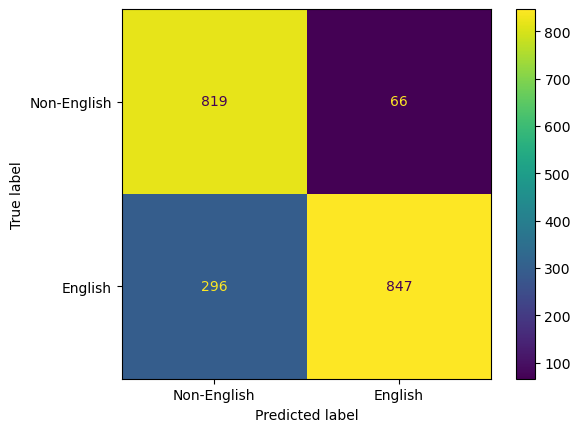

In [88]:
# calculate the matrix
cm = confusion_matrix(target_test, predicted, labels=[0,1])
# display it graphically
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot()
plt.show()

We can look at *precision* and *recall* scores for both classes.

In [89]:
print("Precision (English) = %.4f" % precision_score(target_test, predicted, pos_label=1) )
print("Recall (English) = %.4f" % recall_score(target_test, predicted, pos_label=1) )

Precision (English) = 0.9277
Recall (English) = 0.7410


In [90]:
print("Precision (Non-English) = %.4f" % precision_score(target_test, predicted, pos_label=0) )
print("Recall (Non-English) = %.4f" % recall_score(target_test, predicted, pos_label=0) )

Precision (Non-English) = 0.7345
Recall (Non-English) = 0.9254


We can compute a single value to summarise the performance on each class, using the F1-measure:

In [91]:
print("F1 (English) = %.4f" % f1_score(target_test, predicted, pos_label=1) )
print("F1 (Non-English) = %.4f" % f1_score(target_test, predicted, pos_label=0) )

F1 (English) = 0.8239
F1 (Non-English) = 0.8190


The *classification_report()* functions provides a convenient way of summarising all of this information. Note that *support* here indicates the number of actual occurrences of a class in the test data.

In [92]:
print(classification_report(target_test, predicted, target_names=target_categories))

              precision    recall  f1-score   support

 Non-English       0.73      0.93      0.82       885
     English       0.93      0.74      0.82      1143

    accuracy                           0.82      2028
   macro avg       0.83      0.83      0.82      2028
weighted avg       0.84      0.82      0.82      2028



## Classification and Evaluation - Approach 2

If we re-run the evaluation above several times, we will get different performance scores depending on the randomly-generated training/test split that we are using. A more robust strategy involves using *k-fold cross-validation* to evaluate a classifier.

In the example below, we will evaluate a k-NN classifier using 5-fold cross validation. The model in each fold will be evaluated using accuracy.

In [93]:
# create a single classifier
model = KNeighborsClassifier(n_neighbors=3)
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(model, X, target, cv=5, scoring="accuracy")

In [94]:
# represent the results as a Pandas Series
labels = ["Fold %d" % i for i in range(1,len(acc_scores)+1)]
s_acc = pd.Series(acc_scores, index = labels)
s_acc

Fold 1    0.831361
Fold 2    0.822485
Fold 3    0.821746
Fold 4    0.830621
Fold 5    0.829756
dtype: float64

In [95]:
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.8272


If we wanted to be very thorough, we could repeat this process multiple times (e.g. 10 runs, each with 5 folds). This might take a while, depending on the size of the dataset.

In [96]:
rkf = RepeatedKFold(n_splits=5, n_repeats=10)
# note that we pass RepeatedKFold as the parameter cv
repeated_acc_scores = cross_val_score(model, X, target, cv=rkf, scoring="accuracy")

In [97]:
s_racc = pd.Series(repeated_acc_scores)
s_racc.head(20)

0     0.821006
1     0.826923
2     0.825444
3     0.826183
4     0.823094
5     0.836538
6     0.814349
7     0.823225
8     0.840237
9     0.820873
10    0.829882
11    0.801775
12    0.833580
13    0.833580
14    0.832717
15    0.818787
16    0.838018
17    0.827663
18    0.803994
19    0.839378
dtype: float64

Calculate the mean over all values in the Data Frame:

In [98]:
print("Overall mean accuracy: %.4f" % s_racc.mean() )
print("Overall standard deviation in accuracy: %.4f" % s_racc.std() )

Overall mean accuracy: 0.8270
Overall standard deviation in accuracy: 0.0107


We could use this evaluation process to compare the performance of different classification algorithms on a given corpus.

## Classification and Evaluation with Pipelines

As we saw in the last lab notebook, we can the Scikit-learn *Pipeline* class to connect together a sequence of steps for classification. We can use this to process training and test sets separately when performing evaluations of classifications.

Firstly we define the steps in our pipeline:

In [99]:
from sklearn.pipeline import Pipeline
pipeline1 = Pipeline([
    ('vec', CountVectorizer(min_df = 10, stop_words=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])

Then apply *k-fold cross-validation* using the pipeline for each fold. Note that we pass in the raw documents, as all of the preprocessing steps will be performing for us as part of the pipeline.

In [100]:
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline1, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.7029


Now change the process to use a linear Support Vector Machine (SVM) classifier, and perform the evaluation again:

In [101]:
pipeline2 = Pipeline([
    ('vec', CountVectorizer(stop_words="english")),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

In [102]:
# apply 5-fold cross-validation, measuring accuracy each time
acc_scores = cross_val_score(pipeline2, documents, target, cv=5, scoring="accuracy")
s_acc = pd.Series(acc_scores)
print("Mean accuracy: %.4f" % s_acc.mean())

Mean accuracy: 0.9069
